# Import Packages

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time, warnings

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import re

warnings.filterwarnings("ignore")

# Load The Data

In [2]:
#load the dataset
retail_df = pd.read_csv('data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# Data Preparation

In [3]:
# UK Customers
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [4]:
# remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [5]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [6]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-12-09"]
retail_uk.shape

(176137, 8)

In [7]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary..
Number of transactions:  8789
Number of products bought:  3294
Number of customers: 2864
Percentage of customers NA:  0.0 %


# RFM Analysis

# Recency

In [8]:
#last date available in our dataset to use it as a reference to calculate Recency
retail_uk['InvoiceDate'].max()

'9/9/2011 9:52'

In [9]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [10]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = pd.DatetimeIndex(retail_uk['InvoiceDate']).date

In [11]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,2011-03-01
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,2011-03-01
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,2011-03-01


In [12]:
#group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12747,2011-08-22
1,12748,2011-09-30
2,12749,2011-08-01
3,12820,2011-09-26
4,12821,2011-05-09


In [13]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [14]:
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12747,2011-08-22,109
1,12748,2011-09-30,70
2,12749,2011-08-01,130
3,12820,2011-09-26,74
4,12821,2011-05-09,214


In [15]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

# Frequency

In [16]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12747,5
1,12748,96
2,12749,3
3,12820,1
4,12821,1


# Monetary

In [17]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

In [18]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12747,191.85
1,12748,1054.43
2,12749,67.00
3,12820,15.00
4,12821,19.92


# Create RFM Table

In [19]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12747,109,5
1,12748,70,96
2,12749,130,3
3,12820,74,1
4,12821,214,1


In [20]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,109,5,191.85
12748,70,96,1054.43
12749,130,3,67.00
12820,74,1,15.00
12821,214,1,19.92


# RFM Table Correctness Verification

In [21]:
retail_uk[retail_uk['CustomerID']=='12820']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
360567,568236,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,9/26/2011 11:49,3.75,12820,United Kingdom,2011-09-26,15.0


In [22]:
(now - dt.date(2011,9,26)).days == 74

True

# Customer Segments With RFM Model

# RFM Quartiles

In [23]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,85.0,1.0,16.35
0.50,119.0,2.0,35.40
0.75,183.0,3.0,92.42


In [24]:
quantiles.to_dict()

{'Recency': {0.25: 85.0, 0.5: 119.0, 0.75: 183.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'Monetary': {0.25: 16.35, 0.5: 35.400000000000006, 0.75: 92.42000000000002}}

# Creation of RFM Segments

In [25]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [26]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [27]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12747,109,5,191.85,3,4,4
12748,70,96,1054.43,4,4,4
12749,130,3,67.00,2,3,3
12820,74,1,15.00,4,1,1
12821,214,1,19.92,1,1,2


In [28]:
# combine the scores (R_Quartile, F_Quartile,M_Quartile) together
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12747,109,5,191.85,3,4,4,344
12748,70,96,1054.43,4,4,4,444
12749,130,3,67.00,2,3,3,233
12820,74,1,15.00,4,1,1,411
12821,214,1,19.92,1,1,2,112


In [29]:
# Best Recency score = 4: most recently purchase.
# Best Frequency score = 4: most quantity purchase. 
# Best Monetary score = 4: spent the most.
# Get best customers 
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
18102,72,34,26632.62,4,4,4,444
17949,70,32,22504.73,4,4,4,444
17450,70,28,18009.06,4,4,4,444
16029,80,39,15119.49,4,4,4,444
16013,70,24,10402.34,4,4,4,444
12901,81,20,5915.66,4,4,4,444
13798,72,34,4648.80,4,4,4,444
17857,72,12,4644.68,4,4,4,444
13694,71,32,4472.68,4,4,4,444


In [30]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  218
Loyal Customers:  687
Big Spenders:  716
Almost Lost:  52
Lost Customers:  5
Lost Cheap Customers:  278


In [31]:
def FreqPlot(myTable, Col, wanna_save):
    chart = sns.countplot(myTable[Col],label="Counts")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.gcf().subplots_adjust(bottom=0.30)
    plt.ylabel('No. of Frequencies')
    plt.xlabel('%s' %re.sub('[^A-Za-z0-9]+', ' ', Col))
    plt.title('%s Frequencies' %re.sub('[^A-Za-z0-9]+', ' ', Col))
    if wanna_save: 
        plt.savefig('%s.pdf' % Col)
    plt.show()

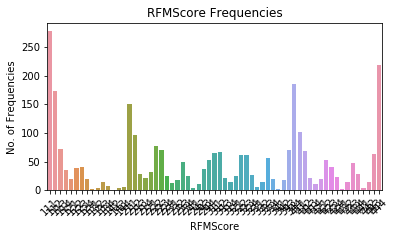

In [32]:
FreqPlot(rfm_segmentation,'RFMScore', False)

# ToDo: Segment Customers for a Clearer Plot

In [33]:
def rfm_segment(x):
    if x == '444':
        return 'Best Customer'
    elif x == '111':
        return 'Lost Cheap Customer'
    elif x == '244':
        return 'Almost Lost Customer'
    elif x == '144':
        return 'Lost Customer'
    elif (x.find('1') == 4): 
        return 'Loyal Customer'
    elif (x.find('1') == 4): 
        return 'Big Spender'
    elif (x.find('1') == 0): 
        return 'New Customer'
    else: 
        return 'Normal Customers'